# Step 1: Importing the required libraries and Reading data from the dataset

In [1]:
!pip install wordcloud

In [2]:
import numpy as np 
import pandas as pd 
import os
import torch
import wordcloud
import seaborn as sn
import matplotlib.pyplot as plt
import time
import seaborn as sn
from tqdm.notebook import tqdm
import nltk

from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

for dirname, _, filenames in os.walk('/Sentiment Analysis Employee Review/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

TRAINED_MODELS_FOLDER = 'trained_models'
if not os.path.exists(TRAINED_MODELS_FOLDER):
    os.makedirs(TRAINED_MODELS_FOLDER)

STATS_FOLDER = 'stats'
if not os.path.exists(STATS_FOLDER):
    os.makedirs(STATS_FOLDER)

ANALYSIS_FOLDER = 'analysis'   
if not os.path.exists(ANALYSIS_FOLDER):
    os.makedirs(ANALYSIS_FOLDER)

In [3]:
#### Setting Random state for repeatability of results
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [5]:
#### Loading Datasets
train_df = pd.read_csv('../Sentiment Analysis Employee Review/dataset/train_set.csv')
train_df.set_index('id', inplace=True)

val_df = pd.read_csv('../Sentiment Analysis Employee Review/dataset/validation_set.csv')
val_df.set_index('id', inplace=True)

test_df = pd.read_csv('../Sentiment Analysis Employee Review/dataset/test_set.csv')
test_df.set_index('id', inplace=True)

# Step 2: Creating features and EDA


In [6]:
### Creating feature vectors
tfidf_vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

tfidf_train_vectors = tfidf_vectorizer.fit_transform(train_df.feedback)
tfidf_val_vectors = tfidf_vectorizer.transform(val_df.feedback)
tfidf_test_vectors = tfidf_vectorizer.transform(test_df.feedback)

tfidf_train_vectors_clean = tfidf_vectorizer.fit_transform(train_df.feedback_clean)
tfidf_val_vectors_clean = tfidf_vectorizer.transform(val_df.feedback_clean)
tfidf_test_vectors_clean = tfidf_vectorizer.transform(test_df.feedback_clean)

count_vectorizer = CountVectorizer()
count_train_vectors = count_vectorizer.fit_transform(train_df.feedback)
count_val_vectors = count_vectorizer.transform(val_df.feedback)
count_test_vectors = count_vectorizer.transform(test_df.feedback)

count_train_vectors_clean = count_vectorizer.fit_transform(train_df.feedback_clean)
count_val_vectors_clean = count_vectorizer.transform(val_df.feedback_clean)
count_test_vectors_clean = count_vectorizer.transform(test_df.feedback_clean)

ml_train_labels = train_df.label
ml_test_tfidf_vectors = tfidf_test_vectors
ml_test_count_vectors = count_test_vectors
ml_test_labels = test_df.label



In [10]:
### Defining helper functions
def run_classifier_experiment(input_train_vectors, train_labels, classifier = svm.SVC(kernel='linear')):
    t0 = time.time()
    classifier.fit(input_train_vectors, train_labels)
    t1 = time.time()
    time_linear_train = t1-t0
    print("Training time: %fs" % (time_linear_train))
    return classifier

def run_classifier_test(classifier, input_val_vectors, val_labels, description="default_experiment"):
    t3 = time.time()
    prediction = classifier.predict(input_val_vectors)
    t2 = time.time()  
    time_linear_predict = t2-t3
    print("Prediction time: %fs" % (time_linear_predict))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    svm_val_report = classification_report(val_labels, prediction, output_dict=True, zero_division=0)

    weighted_avg_f1 = svm_val_report['weighted avg']['f1-score']
   
    test_plot = sn.heatmap(pd.DataFrame(svm_val_report).iloc[:-1, :].T, annot=True,cmap="YlGnBu", ax=ax[0], vmin=0, vmax=1)
    #test_plot.get_figure().savefig(STATS_FOLDER + f'/{description}.png')  

    unique_labels = np.unique(val_labels)
    cm_prediction = confusion_matrix(val_labels, prediction, labels=unique_labels)
    cm_plot = sn.heatmap(cm_prediction, annot=True, annot_kws={"size": 16},cmap="YlGnBu", ax=ax[1], vmin=0, vmax=25)
    #cm_plot.get_figure().savefig(STATS_FOLDER + f'/{description}_cm.png')
    fig.suptitle(description, fontsize=12)
    plt.show()

    fig.savefig(STATS_FOLDER + f'/{description}_stats.png')

    return prediction, val_labels, weighted_avg_f1

def validate_classic_model(model_description, classifier, train_vectors, train_labels, test_vectors, test_labels, model_results_df):
    print("Configuration: %s" % (model_description))
    classic_model = run_classifier_experiment(train_vectors, train_labels, classifier = classifier)
    test_preds, test_labels, test_weighted_avg_f1 = run_classifier_test(classic_model, test_vectors, test_labels, description=model_description)
    model_results_df.loc[len(model_results_df)] = [model_description, test_weighted_avg_f1]


# Step 3: Feature Engineering

In [8]:
### Model Evaluation Configuration
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

classic_model_results_df = pd.DataFrame(columns=['model_configuration','weighted_avg_f1'])

Configuration: multinomialMB_alpha_.2_tfidf
Training time: 0.002005s
Prediction time: 0.000000s


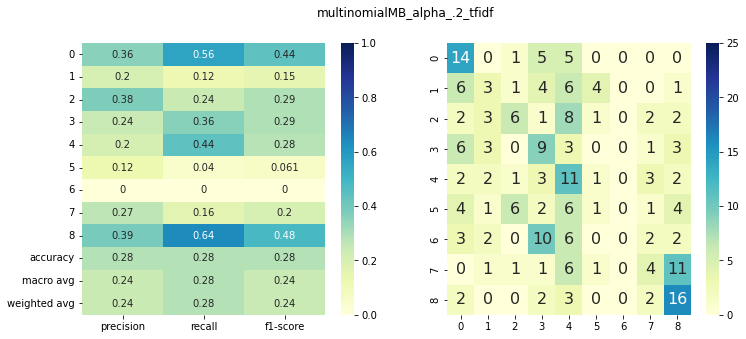

Configuration: multinomialMB_alpha_.2_tfidf_clean
Training time: 0.001512s
Prediction time: 0.000000s


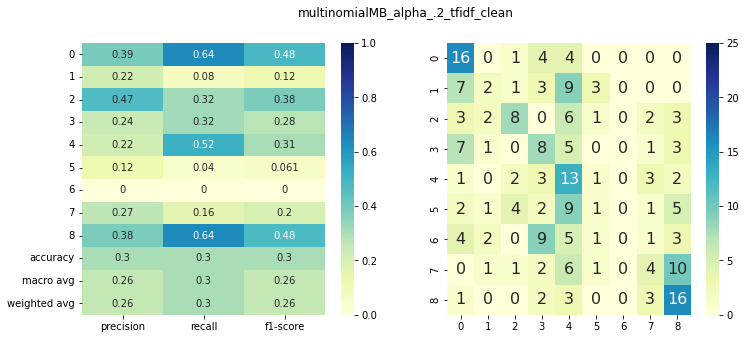

Configuration: multinomialMB_alpha_.2_count
Training time: 0.001940s
Prediction time: 0.000000s


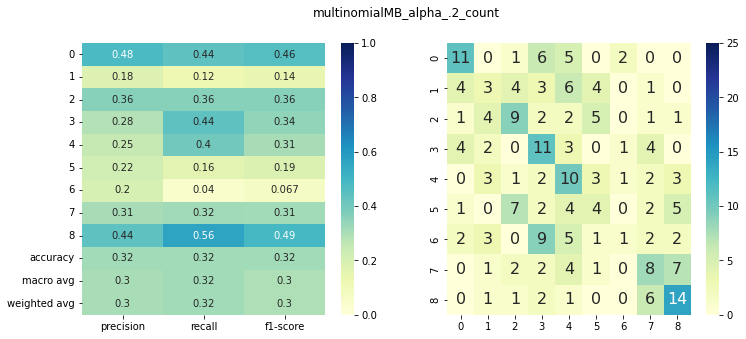

Configuration: multinomialMB_alpha_.2_count_clean
Training time: 0.001943s
Prediction time: 0.000000s


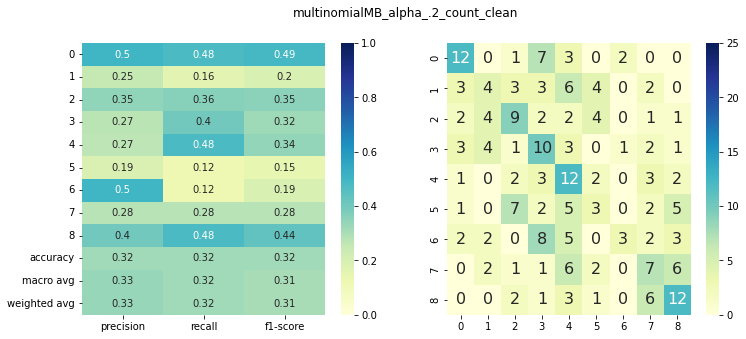

Configuration: SVC_linear_C1.1_tfidf
Training time: 0.233436s
Prediction time: 0.038531s


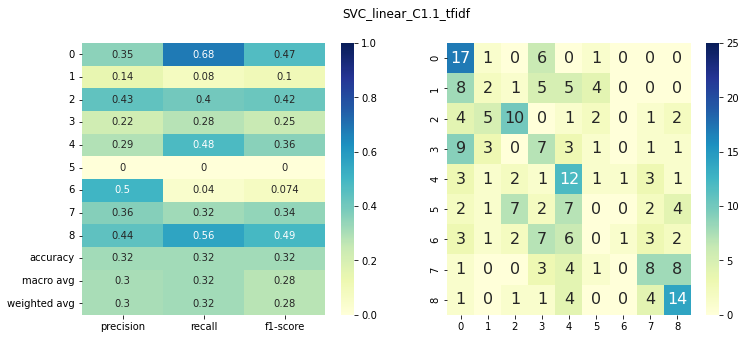

Configuration: SVC_linear_C1.1_tfidf_clean
Training time: 0.215469s
Prediction time: 0.039744s


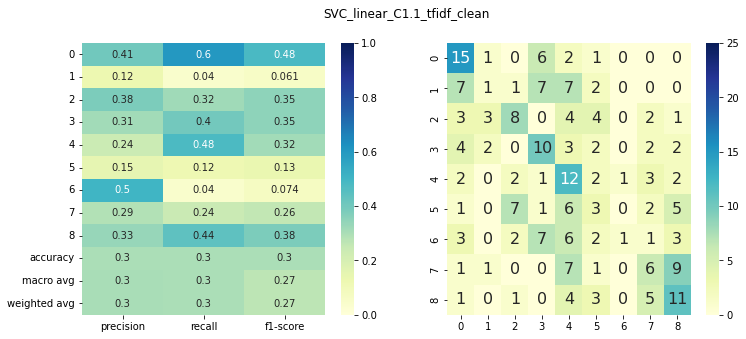

Configuration: SVC_linear_C1.1_count
Training time: 0.273294s
Prediction time: 0.045053s


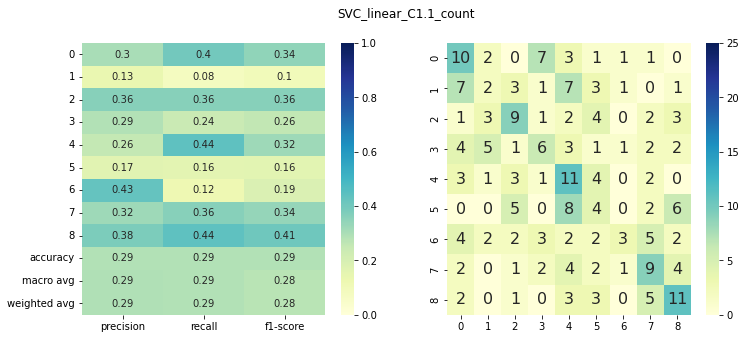

Configuration: SVC_linear_C1.1_count_clean
Training time: 0.264968s
Prediction time: 0.044604s


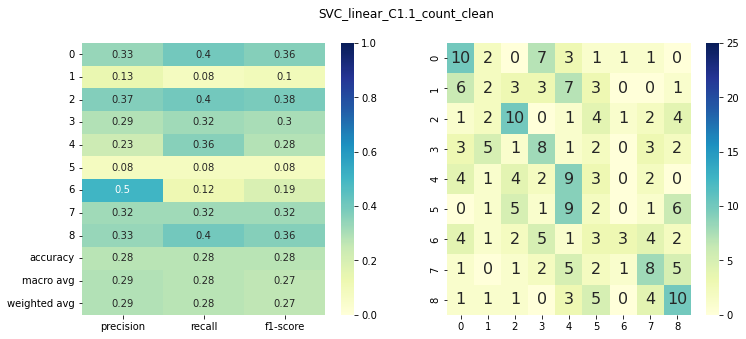

Configuration: SVC_default_rbf_C2.5_tfidf
Training time: 0.224521s
Prediction time: 0.044087s


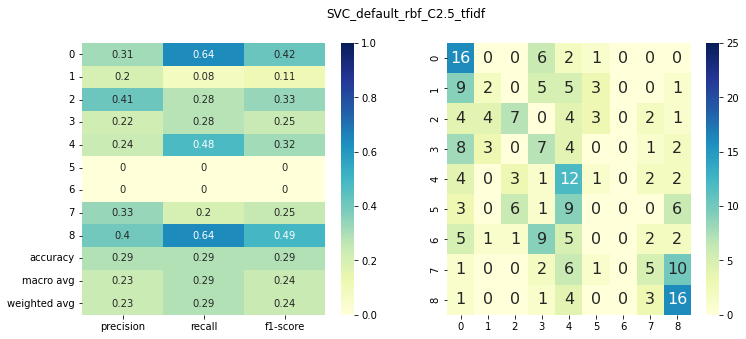

Configuration: SVC_default_rbf_C2.5_tfidf_clean
Training time: 0.226418s
Prediction time: 0.041177s


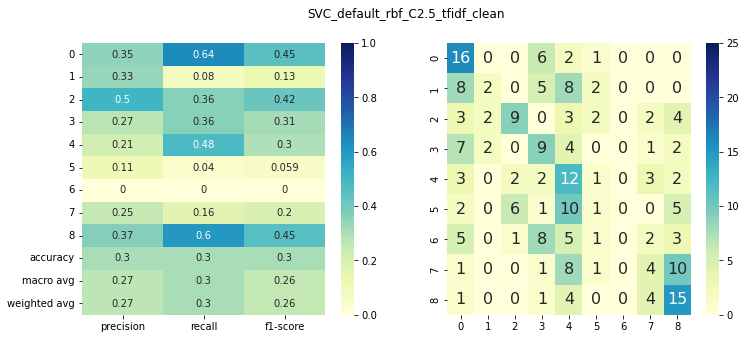

Configuration: SVC_default_rbf_C2.5_count
Training time: 0.272736s
Prediction time: 0.055752s


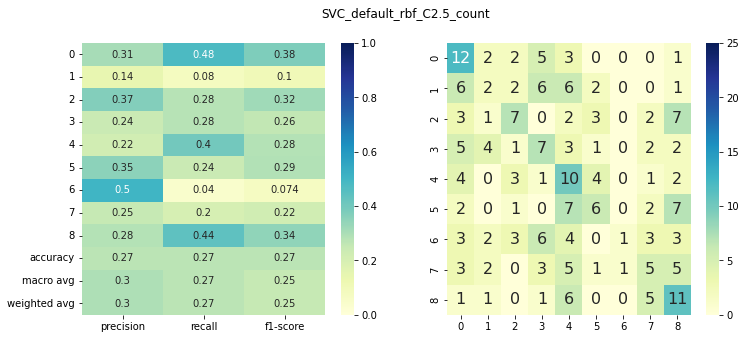

Configuration: SVC_default_rbf_C2.5_count_clean
Training time: 0.272710s
Prediction time: 0.047954s


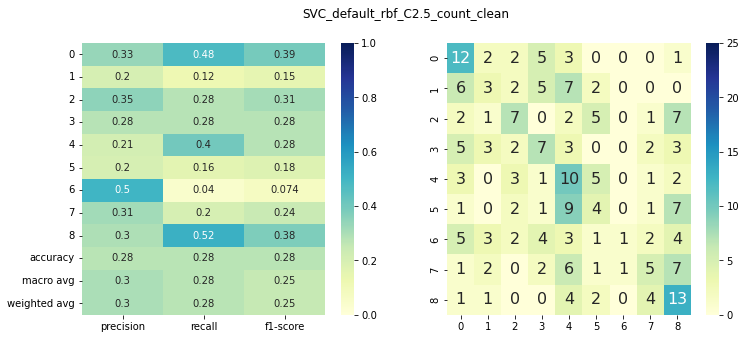

Configuration: RandomForest_tfidf
Training time: 0.247534s
Prediction time: 0.033551s


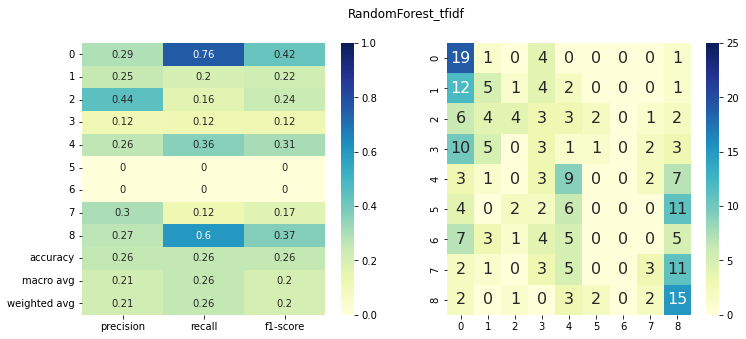

Configuration: RandomForest_tfidf_clean
Training time: 0.201371s
Prediction time: 0.030050s


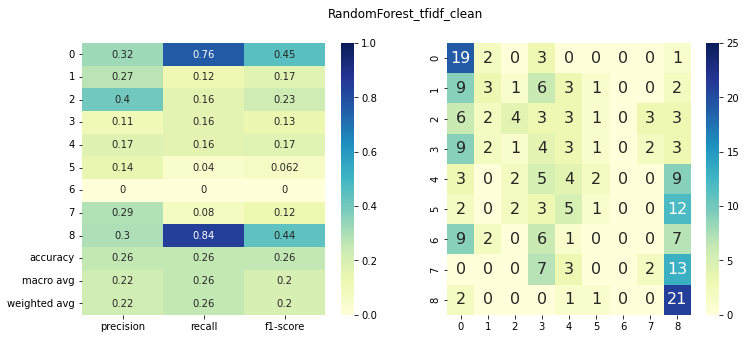

Configuration: RandomForest_count
Training time: 0.343737s
Prediction time: 0.029040s


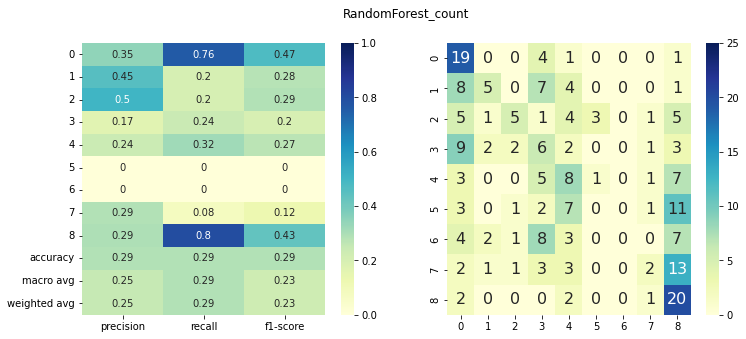

Configuration: RandomForest_count_clean
Training time: 0.181494s
Prediction time: 0.032676s


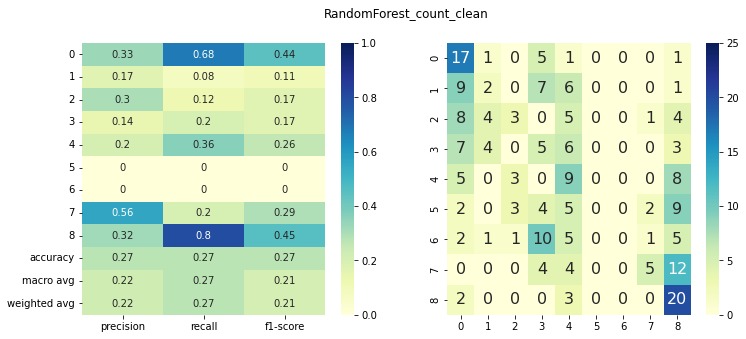

Configuration: LogisticRegression_liblinear_tfidf
Training time: 0.011545s
Prediction time: 0.000000s


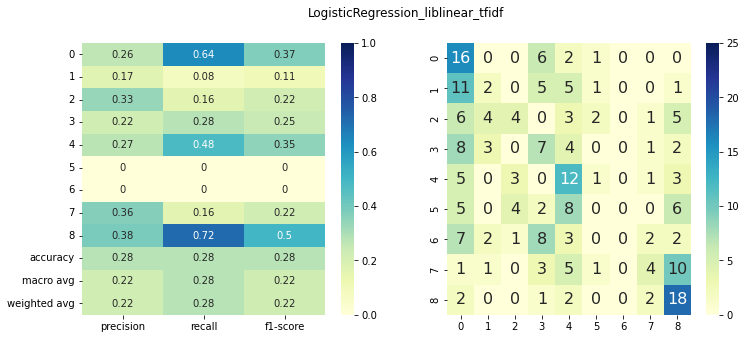

Configuration: LogisticRegression_liblinear_tfidf_clean
Training time: 0.010016s
Prediction time: 0.001007s


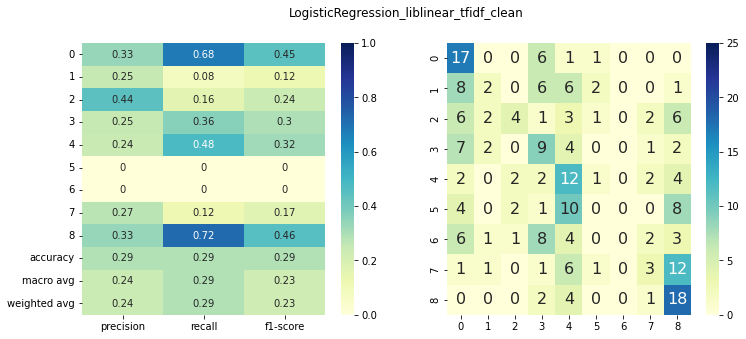

Configuration: LogisticRegression_liblinear_count
Training time: 0.035553s
Prediction time: 0.001784s


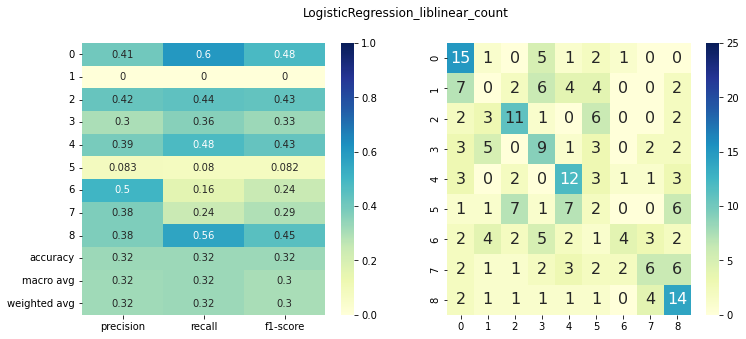

Configuration: LogisticRegression_liblinear_count_clean
Training time: 0.035181s
Prediction time: 0.000000s


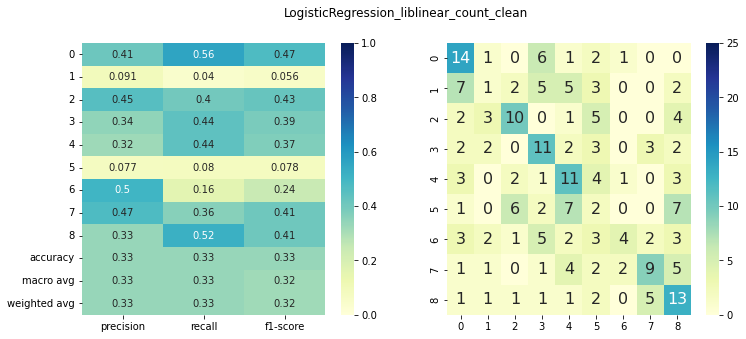

Configuration: LogisticRegression_lbfgs_tfidf
Training time: 0.062725s
Prediction time: 0.000995s


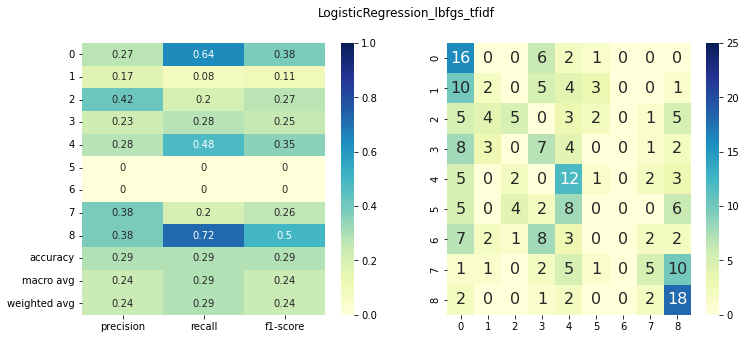

Configuration: LogisticRegression_lbfgs_tfidf_clean
Training time: 0.067255s
Prediction time: 0.001000s


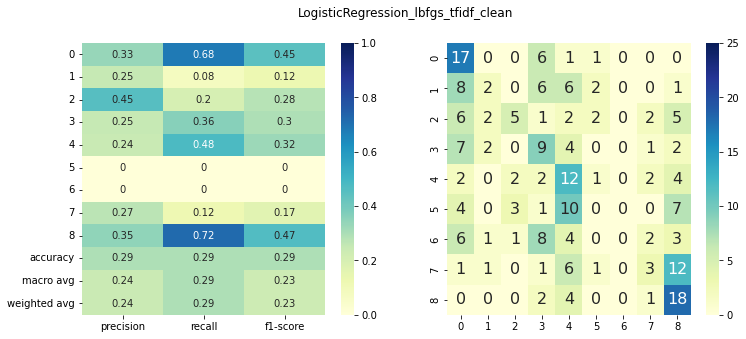

Configuration: LogisticRegression_lbfgs_count
Training time: 0.812410s
Prediction time: 0.000000s


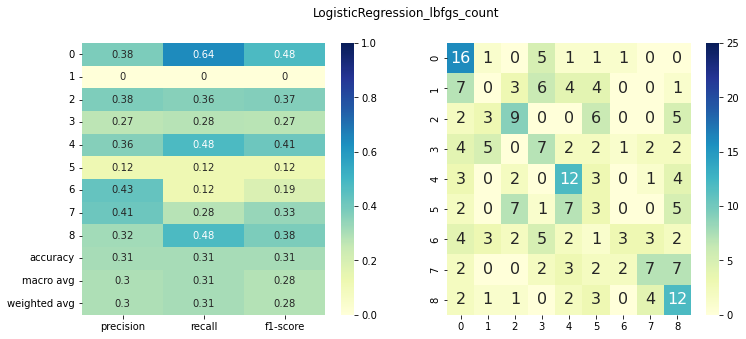

Configuration: LogisticRegression_lbfgs_count_clean
Training time: 0.823997s
Prediction time: 0.001000s


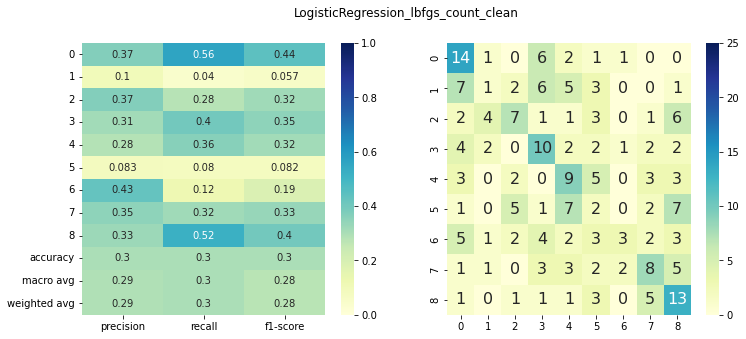

In [11]:
### Evaluating the efficiency of the model
validate_classic_model(
    model_description = "multinomialMB_alpha_.2_tfidf",
    classifier = MultinomialNB(alpha=.2),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "multinomialMB_alpha_.2_tfidf_clean",
    classifier = MultinomialNB(alpha=.2),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "multinomialMB_alpha_.2_count",
    classifier = MultinomialNB(alpha=.2),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "multinomialMB_alpha_.2_count_clean",
    classifier = MultinomialNB(alpha=.2),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_linear_C1.1_tfidf",
    classifier = SVC(kernel='linear', C=1.1),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_linear_C1.1_tfidf_clean",
    classifier = SVC(kernel='linear', C=1.1),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_linear_C1.1_count",
    classifier = SVC(kernel='linear', C=1.1),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_linear_C1.1_count_clean",
    classifier = SVC(kernel='linear', C=1.1),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_default_rbf_C2.5_tfidf",
    classifier = SVC(kernel='rbf', C=2.5),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_default_rbf_C2.5_tfidf_clean",
    classifier = SVC(kernel='rbf', C=2.5),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_default_rbf_C2.5_count",
    classifier = SVC(kernel='rbf', C=2.5),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "SVC_default_rbf_C2.5_count_clean",
    classifier = SVC(kernel='rbf', C=2.5),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "RandomForest_tfidf",
    classifier = RandomForestClassifier(n_jobs=-1, random_state=17),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "RandomForest_tfidf_clean",
    classifier = RandomForestClassifier(n_jobs=-1, random_state=17),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "RandomForest_count",
    classifier = RandomForestClassifier(n_jobs=-1, random_state=17),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "RandomForest_count_clean",
    classifier = RandomForestClassifier(n_jobs=-1, random_state=17),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_liblinear_tfidf",
    classifier = LogisticRegression(fit_intercept=True, solver='liblinear'),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_liblinear_tfidf_clean",
    classifier = LogisticRegression(fit_intercept=True, solver='liblinear'),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_liblinear_count",
    classifier = LogisticRegression(fit_intercept=True, solver='liblinear'),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_liblinear_count_clean",
    classifier = LogisticRegression(fit_intercept=True, solver='liblinear'),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_lbfgs_tfidf",
    classifier = LogisticRegression(fit_intercept=True, solver='lbfgs'),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_lbfgs_tfidf_clean",
    classifier = LogisticRegression(fit_intercept=True, solver='lbfgs'),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_lbfgs_count",
    classifier = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=200),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "LogisticRegression_lbfgs_count_clean",
    classifier = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=200),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {'bootstrap': [True],
     'max_depth': [6, 10],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [3, 5],
     'min_samples_split': [4, 6],
     'n_estimators': [100, 350]
    }
     

forest_clf = RandomForestClassifier()

forest_grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                                  scoring="accuracy",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)

forest_grid_search.fit(tfidf_train_vectors, ml_train_labels)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [6, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [4, 6],
                         'n_estimators': [100, 350]},
             return_train_score=True, scoring='accuracy', verbose=True)

In [13]:
forest_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 350}

Configuration: gradient_boost_tfidf
Training time: 46.222327s
Prediction time: 0.198228s


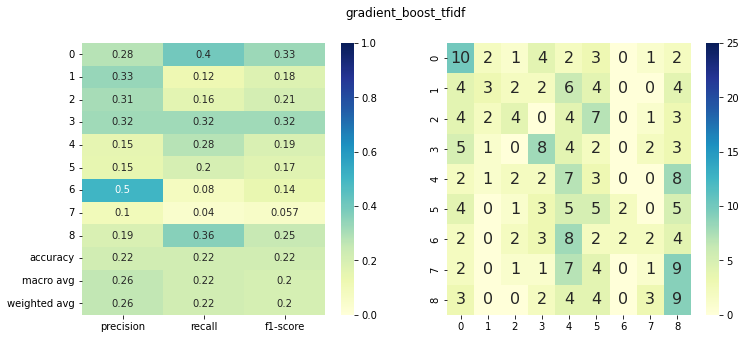

Configuration: gradient_boost_tfidf_clean
Training time: 46.239336s
Prediction time: 0.188087s


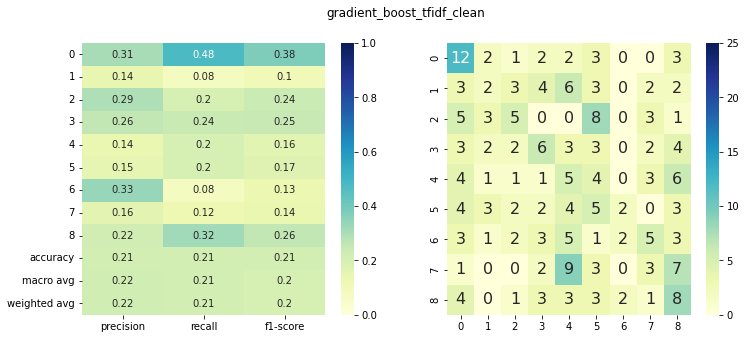

Configuration: gradient_boost_count
Training time: 27.128141s
Prediction time: 0.117394s


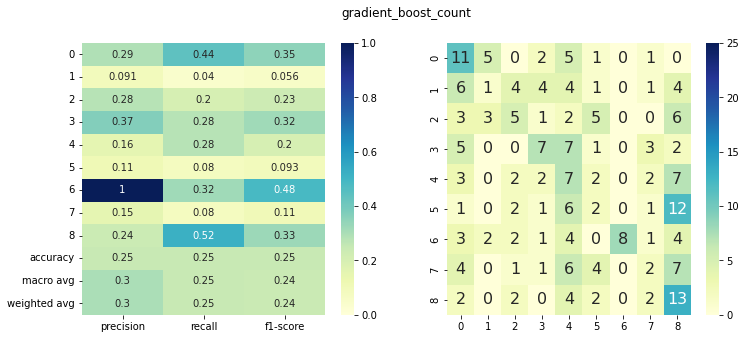

Configuration: gradient_boost_clean
Training time: 26.870860s
Prediction time: 0.126938s


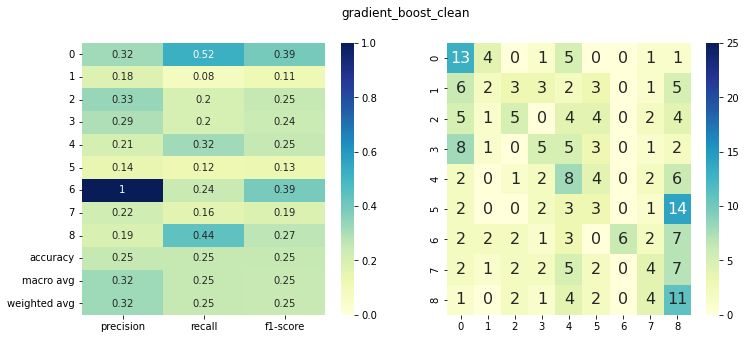

In [14]:
### Applying Gradient Boost
validate_classic_model(
    model_description = "gradient_boost_tfidf",
    classifier = GradientBoostingClassifier(random_state=seed_val, max_depth=10, max_features='auto', min_samples_leaf=3, min_samples_split=4, n_estimators=350),
    train_vectors = tfidf_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_tfidf_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "gradient_boost_tfidf_clean",
    classifier = GradientBoostingClassifier(random_state=seed_val, max_depth=10, max_features='auto', min_samples_leaf=3, min_samples_split=4, n_estimators=350),
    train_vectors = tfidf_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = tfidf_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "gradient_boost_count",
    classifier = GradientBoostingClassifier(random_state=seed_val, max_depth=10, max_features='auto', min_samples_leaf=3, min_samples_split=4, n_estimators=350),
    train_vectors = count_train_vectors,
    train_labels = ml_train_labels,
    test_vectors = ml_test_count_vectors,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

validate_classic_model(
    model_description = "gradient_boost_clean",
    classifier = GradientBoostingClassifier(random_state=seed_val, max_depth=10, max_features='auto', min_samples_leaf=3, min_samples_split=4, n_estimators=350),
    train_vectors = count_train_vectors_clean,
    train_labels = ml_train_labels,
    test_vectors = count_test_vectors_clean,
    test_labels = ml_test_labels,
    model_results_df = classic_model_results_df
)

# Step 4: Retriving final result

In [15]:
### Final Result
classic_model_results_df.index += 1 
classic_model_results_df.to_csv(STATS_FOLDER +'/classic_model_results.csv')
print(classic_model_results_df)

print('\nWinner:')

print(classic_model_results_df.loc[classic_model_results_df['weighted_avg_f1'] == classic_model_results_df['weighted_avg_f1'].max()])

print('End of execution')

                         model_configuration  weighted_avg_f1
1               multinomialMB_alpha_.2_tfidf         0.243827
2         multinomialMB_alpha_.2_tfidf_clean         0.255934
3               multinomialMB_alpha_.2_count         0.296700
4         multinomialMB_alpha_.2_count_clean         0.306617
5                      SVC_linear_C1.1_tfidf         0.277171
6                SVC_linear_C1.1_tfidf_clean         0.267395
7                      SVC_linear_C1.1_count         0.276336
8                SVC_linear_C1.1_count_clean         0.265397
9                 SVC_default_rbf_C2.5_tfidf         0.241376
10          SVC_default_rbf_C2.5_tfidf_clean         0.257053
11                SVC_default_rbf_C2.5_count         0.251384
12          SVC_default_rbf_C2.5_count_clean         0.253877
13                        RandomForest_tfidf         0.204919
14                  RandomForest_tfidf_clean         0.196480
15                        RandomForest_count         0.229056
16      

# Conclusion